# Analysis for DFProfiler

This is a simple analysis notebook for dfprofiler.

## Imports

In [1]:
import logging
import json
import dask
import os
from pathlib import Path
from glob import glob
import math
import zindex_py as zindex
import numpy as np
import intervals as I
import pandas as pd
from tqdm.notebook import trange, tqdm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
import dask.dataframe as dd
from dask.distributed import Client, LocalCluster, progress, wait, get_client
from dask.distributed import Future, get_client

## Project Variables

In [3]:
app_root = str(Path(os.getcwd()).parent)

In [4]:
logging.basicConfig(
    level=logging.INFO,
    handlers=[
        logging.StreamHandler(),
    ],
    format="%(asctime)s [%(levelname)s]: %(message)s in %(pathname)s:%(lineno)d",
)

## Setup Dask Local Cluster

In [5]:
workers=16
cluster = LocalCluster(n_workers=workers)  # Launches a scheduler and workers locally
client = Client(cluster)  # Connect to distributed cluster and override default
logging.info(f"Initialized Client with {workers} workers and link {client.dashboard_link}")

2024-10-24 20:43:55,010 [INFO]: Initialized Client with 16 workers and link http://127.0.0.1:8787/status in /var/tmp/haridev/ipykernel_811081/3142773904.py:4


## Start Analysis

In [6]:

import os 
is_trace = True
ops="write"
output=f"{app_root}/tests/output/jslines"
file=f"{app_root}/tests/output/ops-8192_ts-4m/write.pfw.gz"
# file=f"{app_root}/tests/output/ops-64_ts-64m/RAW-BUFFERED.pfw.gz"
output_file=f"{output}/{ops}_"+os.path.basename(os.path.dirname(file))+"-"+ os.path.basename(file) + ".jsonl"
file_pattern = glob(file)
file_pattern, output_file

(['/usr/WS2/haridev/datacrumbs/tests/output/ops-8192_ts-4m/write.pfw.gz'],
 '/usr/WS2/haridev/datacrumbs/tests/output/jslines/write_ops-8192_ts-4m-write.pfw.gz.jsonl')

## Function to load trace data

In [7]:
def create_index(filename):
    index_file = f"{filename}.zindex"
    if not os.path.exists(index_file):
        status = zindex.create_index(filename, index_file=f"file:{index_file}",
                                     regex="id:\b([0-9]+)", numeric=True, unique=True, debug=False, verbose=False)
        logging.debug(f"Creating Index for {filename} returned {status}")
    return filename

def get_linenumber(filename):
    index_file = f"{filename}.zindex"
    line_number = zindex.get_max_line(filename, index_file=index_file, debug=False, verbose=False)
    logging.debug(f" The {filename} has {line_number} lines")
    return (filename, line_number)

def get_size(filename):
    if filename.endswith('.pfw'):
        size = os.stat(filename).st_size
    elif filename.endswith('.pfw.gz'):
        index_file = f"{filename}.zindex"
        line_number = zindex.get_max_line(filename, index_file=index_file,debug=False, verbose=False)
        size = line_number * 256
    logging.debug(f" The {filename} has {size/1024**3} GB size")
    return int(size)


def generate_line_batches(filename, max_line):
    batch_size = 16*1024
    for start in range(0, max_line, batch_size):
        end =  min((start + batch_size - 1) , (max_line - 1))
        logging.debug(f"Created a batch for {filename} from [{start}, {end}] lines")
        yield filename, start, end

def load_indexed_gzip_files(filename, start, end):
    index_file = f"{filename}.zindex"
    json_lines = zindex.zquery(filename, index_file=index_file,
                          raw=f"select a.line from LineOffsets a where a.line >= {start} AND a.line <= {end};", debug=False, verbose=False)
    logging.debug(f"Read {len(json_lines)} json lines for [{start}, {end}]")
    return json_lines

In [8]:
def load_profile(line):
    d = {}
    if line is not None and line !="" and len(line) > 0 and "[" != line[0] and line != "\n" :
        try:
            unicode_line = ''.join([i if ord(i) < 128 else '#' for i in line])
            val = json.loads(unicode_line)
            if "pid" in d:
                d["pid"] = val["pid"]
            if "tid" in d:
                d["tid"] = val["tid"]
            if "ts" in d:
                d["ts_us"] = int(val["ts"])
            d["filename"] = "NA"
            if "args" in val:
                if "time" in val["args"]:
                    d["dur_sec"] = float(val["args"]["time"])
                if "freq" in val["args"]:
                    d["freq"] = val["args"]["freq"]
                if "size_sum" in val["args"]:
                    d["size_bytes"] = val["args"]["size_sum"]
                if "fname" in val["args"] and val["args"]["fname"]:
                    d["filename"] = val["args"]["fname"]
            d["func_id"] = val["name"]
            d["cat"] = val["cat"]
        except Exception as error:
            logging.error(f"Processing {line} failed with {error}")
    return d


def load_trace(line):
    d = {}
    if line is not None and line !="" and len(line) > 0 and "[" != line[0] and line != "\n" :
        try:
            unicode_line = ''.join([i if ord(i) < 128 else '#' for i in line])
            val = json.loads(unicode_line)
            d["name"] = val["name"]
            d["cat"] = val["cat"]
            if "pid" in val:
                d["pid"] = val["pid"]
            if "tid" in val:
                d["tid"] = val["tid"]
            d["ts"] = 0
            d["dur"] = 0
            if "ts" in val:
                d["ts"] = int(val["ts"])
                d["te"] = int(val["ts"])
            d["dur"] = 1
            if "dur" in val:
                d["dur"] = int(val["dur"])
            if "args" in val and "hhash" in val["args"]:                    
                d["hhash"] = val["args"]["hhash"]
            if "ts" in val:
                interval = I.closedopen(d["ts"], d["ts"] + 1)
                if d["dur"] > 0:
                    d["te"] = int(val["ts"]) + d["dur"]
                    interval = I.closedopen(d["ts"], d["ts"] + d["dur"])
                d["interval"] = I.to_string(interval)
            if val["ph"] != "M":
                d["type"] = 0    
                if "args" in val:                    
                    if "hhash" in val["args"]:
                        d["hhash"] = val["args"]["hhash"]
                    if "size_sum" in val["args"]:
                        d["size"] = val["args"]["size_sum"]
                    if "fhash" in val["args"]:
                        d["fhash"] = val["args"]["fhash"]
            else:
                if val["name"] == "FH":
                    d["type"] = 1
                    if "args" in val:
                        if "name" in val["args"]:
                            d["name"] = val["args"]["name"]
                        if "value" in val["args"]:
                            d["hash"] = val["args"]["value"]
                elif val["name"] == "HH":
                    d["type"] = 2
                    if "args" in val:
                        if "name" in val["args"]:
                            d["name"] = val["args"]["name"]
                        if "value" in val["args"]:
                            d["hash"] = val["args"]["value"]
            
        except Exception as error:
            logging.error(f"Processing {line} failed with {error}")
    return d

## Create Dask Dataframe

In [10]:
if len(file_pattern) > 0:
    dask.bag.from_sequence(file_pattern).map(create_index).compute()
    logging.info(f"Created index for {len(file_pattern)} files")
    total_size = dask.bag.from_sequence(file_pattern).map(get_size).sum()
    n_partition = math.ceil(total_size.compute() / (128 * 1024 ** 2))
    logging.info(f"Total size of all files are {total_size} bytes")
    max_line_numbers = dask.bag.from_sequence(file_pattern).map(get_linenumber).compute()
    logging.info(f"Max lines per file are {max_line_numbers}")
    json_line_delayed = []
    total_lines = 0
    for filename, max_line in max_line_numbers:
        total_lines += max_line
        for _, start, end in generate_line_batches(filename, max_line):
            json_line_delayed.append((filename, start, end))

    logging.info(f"Loading {len(json_line_delayed)} batches out of {len(file_pattern)} files and has {total_lines} lines overall")
    json_line_bags = []
    for filename, start, end in json_line_delayed:
        num_lines = end - start + 1
        json_line_bags.append(dask.delayed(load_indexed_gzip_files, nout=num_lines)(filename, start, end))
    json_lines = dask.bag.concat(json_line_bags)
    if is_trace:
        pfw_bag = json_lines.map(load_trace).filter(lambda x: "name" in x)
    else:
        pfw_bag = json_lines.map(load_profile).filter(lambda x: "func_id" in x)
    pfw_bag.take(1)

2024-10-24 20:44:40,067 [INFO]: Created index for 1 files in /var/tmp/haridev/ipykernel_811081/864066620.py:3
2024-10-24 20:44:40,193 [INFO]: Total size of all files are <dask.bag.core.Item object at 0x1554da102f10> bytes in /var/tmp/haridev/ipykernel_811081/864066620.py:6
2024-10-24 20:44:40,282 [INFO]: Max lines per file are [('/usr/WS2/haridev/datacrumbs/tests/output/ops-8192_ts-4m/write.pfw.gz', 6013218)] in /var/tmp/haridev/ipykernel_811081/864066620.py:8
2024-10-24 20:44:40,285 [INFO]: Loading 368 batches out of 1 files and has 6013218 lines overall in /var/tmp/haridev/ipykernel_811081/864066620.py:16


In [11]:
if is_trace:
    columns = {'hhash': "string[pyarrow]", 'pid': "uint64[pyarrow]", 'tid': "uint64[pyarrow]",
                'cat': "string[pyarrow]", 'name': "string[pyarrow]", 'type':  "uint8[pyarrow]",
            'ts': "uint64[pyarrow]", 'te': "uint64[pyarrow]", 'dur': "uint64[pyarrow]", 'interval': "string[pyarrow]", 
             'size': "uint64[pyarrow]", 'fhash': "string[pyarrow]", 'hash': "string[pyarrow]", 
           }
else:
    columns = {'pid': "uint64[pyarrow]", 'tid': "uint64[pyarrow]",
            'ts_us': "uint64[pyarrow]", 'dur_sec': "float32[pyarrow]", 
            'freq': "uint64[pyarrow]", 'size_bytes': "uint64[pyarrow]", 'name': "string[pyarrow]", 
            'filename': "string[pyarrow]", 
            'cat': "string[pyarrow]"}

In [12]:
events = pfw_bag.to_dataframe(meta=columns)

In [13]:
events = events.repartition(npartitions=n_partition).persist()
_ = wait(events)

In [14]:
fhash = events.query("type == 1")[["name","hash"]]
hhash = events.query("type == 2")[["name","hash"]]
event = events.query("type == 0")
fhashes = fhash.query("name.str.contains('file_0')").compute()["hash"]
fhashes = fhashes.to_list()


In [15]:
fhashes

['194689688332679803833173472027673291574']

In [16]:
event.query("fhash.isin(@value)", local_dict={"value": fhashes}).compute()

,hhash,pid,tid,cat,name,type,ts,te,dur,interval,size,fhash,hash
7265,62269085204815009254311364333032584385,8830,8830,sys,openat,0,138677,138680,3,"[138677,138680)",<NA>,194689688332679803833173472027673291574,<NA>
14835,62269085204815009254311364333032584385,8830,8830,sys,write,0,180823,187702,6879,"[180823,187702)",4194304,194689688332679803833173472027673291574,<NA>
5956,62269085204815009254311364333032584385,8830,8830,sys,write,0,229330,236130,6800,"[229330,236130)",4194304,194689688332679803833173472027673291574,<NA>
13457,62269085204815009254311364333032584385,8830,8830,sys,write,0,272526,278794,6268,"[272526,278794)",4194304,194689688332679803833173472027673291574,<NA>
4578,62269085204815009254311364333032584385,8830,8830,sys,write,0,319657,329788,10131,"[319657,329788)",4194304,194689688332679803833173472027673291574,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14821,62269085204815009254311364333032584385,8830,8830,sys,write,0,629260891,629269742,8851,"[629260891,629269742)",4194304,194689688332679803833173472027673291574,<NA>
14969,62269085204815009254311364333032584385,8830,8830,sys,write,0,629480343,629492216,11873,"[629480343,629492216)",4194304,194689688332679803833173472027673291574,<NA>
15044,62269085204815009254311364333032584385,8830,8830,sys,write,0,629608705,629619671,10966,"[629608705,629619671)",4194304,194689688332679803833173472027673291574,<NA>
15377,62269085204815009254311364333032584385,8830,8830,sys,write,0,630215483,630227433,11950,"[630215483,630227433)",4194304,194689688332679803833173472027673291574,<NA>


In [17]:
ops

'write'

## Analysis

In [18]:

interesting_events = event.query("fhash.isin(@value) and name == @ops", local_dict={"value": fhashes, "ops": ops})
interesting_events.compute()

,hhash,pid,tid,cat,name,type,ts,te,dur,interval,size,fhash,hash
14835,62269085204815009254311364333032584385,8830,8830,sys,write,0,180823,187702,6879,"[180823,187702)",4194304,194689688332679803833173472027673291574,<NA>
5956,62269085204815009254311364333032584385,8830,8830,sys,write,0,229330,236130,6800,"[229330,236130)",4194304,194689688332679803833173472027673291574,<NA>
13457,62269085204815009254311364333032584385,8830,8830,sys,write,0,272526,278794,6268,"[272526,278794)",4194304,194689688332679803833173472027673291574,<NA>
4578,62269085204815009254311364333032584385,8830,8830,sys,write,0,319657,329788,10131,"[319657,329788)",4194304,194689688332679803833173472027673291574,<NA>
12181,62269085204815009254311364333032584385,8830,8830,sys,write,0,374972,385069,10097,"[374972,385069)",4194304,194689688332679803833173472027673291574,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14259,62269085204815009254311364333032584385,8830,8830,sys,write,0,628458712,628467936,9224,"[628458712,628467936)",4194304,194689688332679803833173472027673291574,<NA>
14821,62269085204815009254311364333032584385,8830,8830,sys,write,0,629260891,629269742,8851,"[629260891,629269742)",4194304,194689688332679803833173472027673291574,<NA>
14969,62269085204815009254311364333032584385,8830,8830,sys,write,0,629480343,629492216,11873,"[629480343,629492216)",4194304,194689688332679803833173472027673291574,<NA>
15044,62269085204815009254311364333032584385,8830,8830,sys,write,0,629608705,629619671,10966,"[629608705,629619671)",4194304,194689688332679803833173472027673291574,<NA>


In [19]:
interesting_intervals  = interesting_events["interval"].compute()
interesting_intervals

14835          [180823,187702)
5956           [229330,236130)
13457          [272526,278794)
4578           [319657,329788)
12181          [374972,385069)
                 ...          
14259    [628458712,628467936)
14821    [629260891,629269742)
14969    [629480343,629492216)
15044    [629608705,629619671)
15377    [630215483,630227433)
Name: interval, Length: 1315, dtype: string

In [20]:

# interesting_events["interval"] = interesting_events.apply(lambda x: I.to_string(I.closed(x["ts"], x["ts"]+x["dur"])), axis=1)

In [21]:
def group_func(df):
    val = I.empty()
    for index, value in df.items():
        if str(value) != 'NA':
            pad_interval = I.from_string(str(value), int)
            val = val.union(pad_interval)
    logging.debug(f"Grouped Range into {val}")
    return I.to_string(val)
def union_portions():
    return dd.Aggregation(
        'union_portions',
        chunk=lambda s: s.apply(group_func),
        agg=lambda s: s.apply(group_func)
    )
relevant_intervals = interesting_events.reduction(chunk=lambda s: s.apply(group_func), aggregate=lambda s1: s1.apply(group_func))["interval"].compute()
relevant_intervals = I.from_string(relevant_intervals, int)
relevant_intervals_list = list(relevant_intervals)
relevant_intervals_list[:10], len(relevant_intervals_list)

([[180823,187702),
  [229330,236130),
  [272526,278794),
  [319657,329788),
  [374972,385069),
  [421370,429159),
  [466234,473716),
  [511394,519068),
  [554724,563509),
  [599133,605844)],
 1315)

In [22]:
min_ts = relevant_intervals_list[0].lower
max_te = relevant_intervals_list[-1].upper
min_ts, max_te

(180823, 630227433)

In [23]:
filtered_events = event.query(f"ts >= {min_ts - 1e5} and te <= {max_te + 1e5} and dur > 0")
filtered_events.compute()

,hhash,pid,tid,cat,name,type,ts,te,dur,interval,size,fhash,hash
3346,62269085204815009254311364333032584385,8830,8830,c,malloc,0,80823,80824,1,"[80823,80824)",<NA>,<NA>,<NA>
3347,62269085204815009254311364333032584385,8830,8830,c,calloc,0,80825,80826,1,"[80825,80826)",<NA>,<NA>,<NA>
3348,62269085204815009254311364333032584385,8830,8830,c,malloc,0,80826,80827,1,"[80826,80827)",<NA>,<NA>,<NA>
3349,62269085204815009254311364333032584385,8830,8830,c,calloc,0,80828,80829,1,"[80828,80829)",<NA>,<NA>,<NA>
3350,62269085204815009254311364333032584385,8830,8830,c,free,0,80830,80831,1,"[80830,80831)",<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15439,62269085204815009254311364333032584385,8830,8830,kernel,node_page_state,0,630320547,630320548,1,"[630320547,630320548)",<NA>,<NA>,<NA>
15440,62269085204815009254311364333032584385,8830,8830,kernel,__mod_node_page_state,0,630321234,630321235,1,"[630321234,630321235)",<NA>,<NA>,<NA>
15441,62269085204815009254311364333032584385,8830,8830,kernel,node_page_state,0,630321929,630321930,1,"[630321929,630321930)",<NA>,<NA>,<NA>
15442,62269085204815009254311364333032584385,8830,8830,kernel,wait_for_stable_page,0,630322739,630322768,29,"[630322739,630322768)",<NA>,<NA>,<NA>


In [24]:
filtered_events["combined_name"] = filtered_events["name"] + "-" + filtered_events["cat"]
event_batch_per_sys_call = []
for interval in tqdm(relevant_intervals_list):
    batch = filtered_events.query(f"(ts >= {interval.lower} and ts <=  {interval.upper}) or (te >= {interval.lower} and te <=  {interval.upper})")[["combined_name", "dur"]].groupby("combined_name").sum()
    event_batch_per_sys_call.append(batch.compute())


  0%|          | 0/1315 [00:00<?, ?it/s]

In [37]:
merged_df = None
count = 0
for batch in tqdm(event_batch_per_sys_call):
    if merged_df is not None:
        merged_df = merged_df.merge(batch, how='outer', on="combined_name",suffixes=('', f"_{count}"))
    else:
        merged_df = batch
    count += 1
merged_df = merged_df.multiply(1000)

  0%|          | 0/1315 [00:00<?, ?it/s]

In [38]:
dataset = merged_df.transpose()
final_dataset = dataset.reset_index().drop("index", axis=1)
final_dataset["transfer_size"] = 4*1024*1024
final_dataset

combined_name,__free_pages-kernel,__update_blocked_fair-kernel,__update_load_avg_blocked_se-kernel,chacha_block_generic-kernel,file_free_rcu-kernel,free_unref_page-kernel,fuse_file_write_iter-kernel,fuse_fill_write_pages-kernel,fuse_send_write_pages-kernel,profile_tick-kernel,unlock_page-kernel,update_blocked_averages-kernel,vfs_write-vfs,write-sys,transfer_size
0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,6876000,<NA>,6873000,<NA>,<NA>,<NA>,6876000,6879000,4194304
1,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,6797000,<NA>,6795000,<NA>,<NA>,<NA>,6798000,6800000,4194304
2,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,6265000,<NA>,6263000,<NA>,<NA>,<NA>,6265000,6268000,4194304
3,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,10128000,<NA>,10126000,<NA>,<NA>,<NA>,10129000,10131000,4194304
4,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,10094000,<NA>,10091000,<NA>,<NA>,<NA>,10095000,10097000,4194304
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1310,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,9221000,<NA>,9220000,<NA>,<NA>,<NA>,9222000,9224000,4194304
1311,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,8848000,<NA>,8847000,<NA>,<NA>,<NA>,8849000,8851000,4194304
1312,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,11870000,<NA>,11869000,<NA>,<NA>,<NA>,11871000,11873000,4194304
1313,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,10963000,<NA>,10962000,<NA>,<NA>,<NA>,10964000,10966000,4194304


In [39]:
output_file

'/usr/WS2/haridev/datacrumbs/tests/output/jslines/write_ops-8192_ts-4m-write.pfw.gz.jsonl'

In [40]:
final_dataset.to_json(path_or_buf=f"{output_file}",orient='records', lines=True)


In [41]:
files = glob(f"{output}/{ops}_*")
final_dataset_l = []
for file in files:
    final_dataset_l.append(dd.read_json(file))
final_dataset = dd.concat(final_dataset_l).compute().reset_index().drop("index", axis=1)
final_dataset

,__alloc_pages-kernel,__ext4_get_inode_loc-kernel,__ext4_handle_dirty_metadata-kernel,__ext4_journal_get_write_access-kernel,__ext4_journal_start_sb-kernel,__ext4_journal_stop-kernel,__ext4_mark_inode_dirty-kernel,__file_remove_privs-kernel,__filemap_add_folio-kernel,__filemap_get_folio-kernel,...,ext4_num_base_meta_blocks-kernel,ext4_num_overhead_clusters-kernel,ext4_read_bh_nowait-kernel,ext4_valid_block_bitmap-kernel,fscrypt_set_bio_crypt_ctx_bh-kernel,guard_bio_eod-kernel,page_mapping-kernel,fuse_file_write_iter-kernel,fuse_fill_write_pages-kernel,fuse_send_write_pages-kernel
0,2721565.0,1179728.0,124742.0,145196.0,585626.0,173661.0,5083572.0,23273.0,1165739.0,6752740.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1598231.0,640440.0,58560.0,71684.0,321959.0,97695.0,2755751.0,557.0,694279.0,3861826.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2791520.0,1207392.0,117121.0,145352.0,585011.0,181524.0,5173510.0,1186.0,1194364.0,6887730.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2700642.0,1157320.0,112168.0,142121.0,566987.0,163903.0,4956661.0,1110.0,1126938.0,6590467.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2778612.0,1197648.0,116640.0,150963.0,608540.0,175179.0,5153002.0,1192.0,1185737.0,6869744.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2408,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9221000.0,NaN,9220000.0
2409,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8848000.0,NaN,8847000.0
2410,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11870000.0,NaN,11869000.0
2411,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10963000.0,NaN,10962000.0


In [42]:
final_dataset["BW"] = final_dataset["transfer_size"] / (1024 **2) / (final_dataset["write-sys"] / 1e9)

In [43]:
clean_data = final_dataset.fillna(value=0)
clean_data

,__alloc_pages-kernel,__ext4_get_inode_loc-kernel,__ext4_handle_dirty_metadata-kernel,__ext4_journal_get_write_access-kernel,__ext4_journal_start_sb-kernel,__ext4_journal_stop-kernel,__ext4_mark_inode_dirty-kernel,__file_remove_privs-kernel,__filemap_add_folio-kernel,__filemap_get_folio-kernel,...,ext4_num_overhead_clusters-kernel,ext4_read_bh_nowait-kernel,ext4_valid_block_bitmap-kernel,fscrypt_set_bio_crypt_ctx_bh-kernel,guard_bio_eod-kernel,page_mapping-kernel,fuse_file_write_iter-kernel,fuse_fill_write_pages-kernel,fuse_send_write_pages-kernel,BW
0,2721565.0,1179728.0,124742.0,145196.0,585626.0,173661.0,5083572.0,23273.0,1165739.0,6752740.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,696.475620
1,1598231.0,640440.0,58560.0,71684.0,321959.0,97695.0,2755751.0,557.0,694279.0,3861826.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1271.778916
2,2791520.0,1207392.0,117121.0,145352.0,585011.0,181524.0,5173510.0,1186.0,1194364.0,6887730.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,696.273583
3,2700642.0,1157320.0,112168.0,142121.0,566987.0,163903.0,4956661.0,1110.0,1126938.0,6590467.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,725.469375
4,2778612.0,1197648.0,116640.0,150963.0,608540.0,175179.0,5153002.0,1192.0,1185737.0,6869744.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,695.768155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2408,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,9221000.0,0.0,9220000.0,433.651344
2409,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,8848000.0,0.0,8847000.0,451.926336
2410,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,11870000.0,0.0,11869000.0,336.898846
2411,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,10963000.0,0.0,10962000.0,364.763815


In [44]:
ignore_columns = ["transfer_size", "write-sys"]
y_columns = ["BW"]
x_columns = []
for column in clean_data.columns:
    if column not in ignore_columns and column not in y_columns:
        x_columns.append(column)

In [45]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [46]:
# Separating out the features
x = clean_data.loc[:, x_columns].values
y = clean_data.loc[:,y_columns].values

In [47]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
# Fitting Random Forest Regression to the dataset
regressor = RandomForestRegressor(n_estimators=10, random_state=0, oob_score=True)

# Fit the regressor with x and y data
regressor.fit(x, y)

/usr/workspace/haridev/datacrumbs/venv/lib/python3.9/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


/usr/workspace/haridev/datacrumbs/venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


RandomForestRegressor(n_estimators=10, oob_score=True, random_state=0)

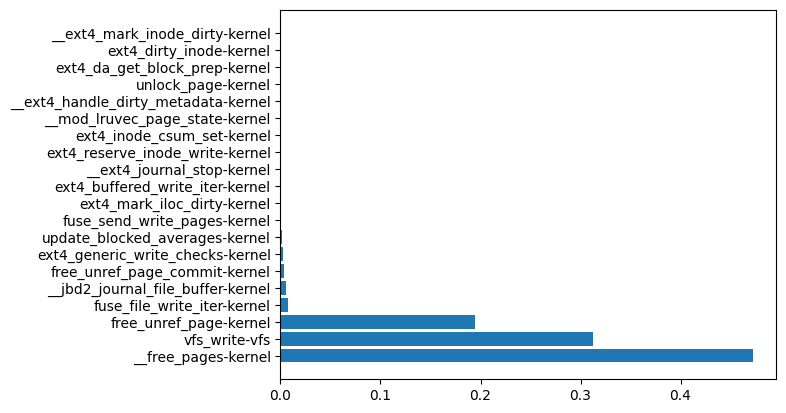

In [48]:
import matplotlib.pyplot as plt
f_i = list(zip(x_columns,regressor.feature_importances_))
f_i.sort(reverse=True, key = lambda x : x[1])
most_f_i = f_i[:20]
plt.barh([x[0] for x in most_f_i],[x[1] for x in most_f_i])
plt.show()

In [83]:
import time

import numpy as np

start_time = time.time()
importances = regressor.feature_importances_
std = np.std([tree.feature_importances_ for tree in regressor.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.007 seconds


In [85]:
importances

array([7.34822119e-04, 6.46598413e-02, 3.01036569e-04, 7.76800512e-04,
       9.35001596e-05, 1.85001522e-04, 6.63121015e-02, 3.44086401e-05,
       1.57495092e-03, 5.47702511e-04, 6.21284823e-04, 0.00000000e+00,
       3.34471813e-06, 6.87796153e-07, 4.64659603e-06, 6.47374607e-02,
       2.31799998e-06, 2.66851263e-04, 2.76461546e-07, 0.00000000e+00,
       0.00000000e+00, 2.72919447e-05, 6.22659560e-02, 1.78110713e-05,
       4.16012273e-06, 7.74248372e-05, 9.86496779e-04, 3.11742491e-03,
       5.47843184e-05, 2.85943183e-10, 1.57072755e-04, 6.18944655e-02,
       0.00000000e+00, 5.33828901e-07, 6.50820302e-04, 1.01568163e-03,
       1.54766745e-04, 5.92477718e-02, 2.51353514e-03, 2.32003068e-12,
       5.44120353e-05, 0.00000000e+00, 4.13866798e-05, 0.00000000e+00,
       2.12808195e-04, 2.55591707e-01, 4.98342205e-06, 0.00000000e+00,
       2.91043465e-05, 1.03236734e-06, 9.45941900e-04, 3.46117607e-06,
       3.71973917e-05, 1.54924618e-04, 3.34091809e-04, 3.66421913e-04,
      

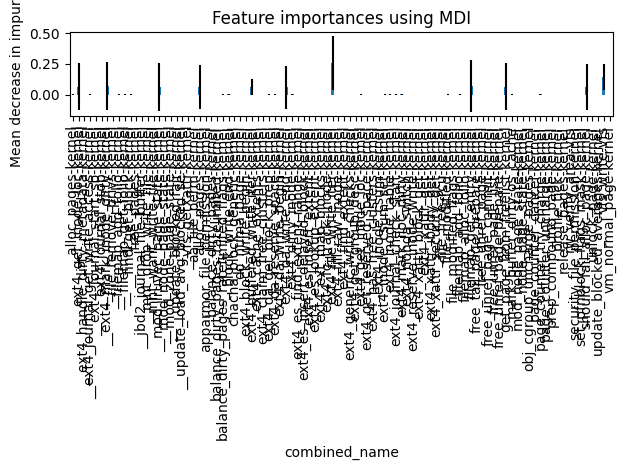

In [84]:
import pandas as pd
import matplotlib.pyplot as plt
forest_importances = pd.Series(importances, index=x_columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [82]:
tree_to_plot = regressor.estimators_[0]

from sklearn.tree import plot_tree
# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(tree_to_plot, feature_names=x_columns, filled=True, rounded=True, fontsize=10)
plt.title("Decision Tree from Random Forest")
plt.show()

KeyboardInterrupt: 

In [45]:
x = StandardScaler().fit_transform(x)

In [55]:
pca = PCA(n_components=len(x_columns))

principalComponents = pca.fit_transform(x)

principalDf = pd.DataFrame(data = principalComponents)

In [60]:
pca.explained_variance_ratio_[:20]

array([0.47625069, 0.12160139, 0.05566985, 0.04548013, 0.04100592,
       0.0255731 , 0.02451993, 0.02257528, 0.02083595, 0.01559983,
       0.01512609, 0.0141261 , 0.01080198, 0.01004007, 0.00906934,
       0.00880016, 0.00825442, 0.00739821, 0.00699101, 0.0067789 ])

In [72]:
PCnames = ['PC'+str(i+1) for i in range(pca.n_components_)]
Loadings = pd.DataFrame(pca.components_,columns=PCnames,index=x_columns)
Loadings = Loadings.abs()
Loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC85,PC86,PC87,PC88,PC89,PC90,PC91,PC92,PC93,PC94
combined_name,,,,,,,,,,,,,,,,,,,,,
__alloc_pages-kernel,0.145330,1.390389e-01,1.354327e-01,2.579734e-02,1.371275e-01,1.413882e-01,1.390908e-01,1.887363e-02,1.436081e-01,1.477985e-01,...,5.590224e-02,4.744203e-02,3.340807e-02,2.701632e-02,7.818356e-04,1.388994e-01,1.388556e-01,1.738430e-02,1.474002e-01,9.035887e-04
__ext4_get_inode_loc-kernel,0.005174,1.679223e-03,2.396381e-03,3.151796e-03,4.168395e-03,3.422959e-03,1.805777e-03,2.859380e-01,5.980225e-03,3.934316e-03,...,1.085126e-02,6.527592e-03,9.608848e-03,9.602746e-03,1.031694e-03,8.720464e-03,4.978606e-03,1.286494e-02,2.263800e-04,1.144707e-03
__ext4_handle_dirty_metadata-kernel,0.013065,1.617875e-02,2.783502e-02,2.117111e-02,1.484592e-02,1.523885e-03,1.790326e-02,6.414692e-04,1.381327e-02,3.316037e-03,...,2.638246e-02,3.944815e-01,2.207419e-02,2.580414e-02,1.509769e-02,2.100594e-02,1.447655e-02,1.191580e-02,1.578659e-03,2.442477e-02
__ext4_journal_get_write_access-kernel,0.025734,1.475944e-01,4.393148e-02,5.575831e-02,1.532197e-01,8.219862e-02,1.367071e-01,3.460486e-02,3.421018e-02,9.664808e-03,...,4.354034e-02,9.285306e-03,4.358687e-01,4.470631e-01,2.159141e-02,2.973016e-02,4.421069e-02,4.268471e-02,5.920266e-02,1.349135e-02
__ext4_journal_start_sb-kernel,0.003622,3.578822e-02,8.550497e-03,1.349077e-02,3.761721e-02,2.003187e-02,3.567506e-02,3.230805e-03,8.573545e-03,1.180436e-03,...,1.880722e-04,5.035241e-02,1.117227e-01,1.119514e-01,6.040199e-03,7.411615e-03,1.498592e-02,5.595074e-02,1.606489e-02,9.835081e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
should_fail_alloc_page-kernel,0.000000,3.600169e-12,4.001301e-14,1.879333e-13,1.230205e-12,2.953258e-13,3.809873e-12,9.408600e-14,1.083039e-12,1.362323e-11,...,3.913536e-15,9.933998e-13,7.030869e-13,4.941434e-13,8.604228e-15,4.010681e-15,1.931233e-13,2.791517e-14,5.258516e-10,9.350791e-13
unlock_page-kernel,0.000000,3.133853e-12,4.186628e-14,2.037182e-13,9.181770e-13,1.987553e-13,1.408288e-12,5.890529e-14,8.615896e-13,1.048478e-11,...,9.214851e-15,7.873077e-13,4.884362e-13,2.943236e-13,5.231926e-15,1.713213e-14,1.752140e-13,5.950102e-15,3.758985e-10,5.616844e-13
update_blocked_averages-kernel,0.000000,3.466791e-12,5.000434e-14,3.346959e-13,9.438232e-13,2.413378e-13,1.371207e-12,5.662535e-14,9.579682e-13,9.483074e-12,...,7.285839e-15,9.545854e-13,5.513090e-13,3.351902e-13,7.355228e-15,1.328451e-14,2.192135e-13,3.491651e-14,4.152051e-10,2.181810e-12


In [76]:
Loadings.iloc[:,0:20][Loadings.gt(0.8).any(axis=1)]

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
combined_name,,,,,,,,,,,,,,,,,,,,
__jbd2_journal_file_buffer-kernel,0.005747,0.000194,0.022220,0.047203,0.005546,0.017421,0.010424,0.000223,0.009979,0.003379,0.014853,0.004950,0.013850,0.034563,0.094439,0.001180,0.00463,0.006885,0.002197,0.066162
ext4_block_write_begin-kernel,0.036387,0.040019,0.024951,0.019709,0.013803,0.008381,0.023247,0.000175,0.010418,0.010879,0.040098,0.263171,0.021948,0.003841,0.003836,0.011998,0.01353,0.037141,0.006561,0.007063


np.float64(-0.4846718563025322)

In [51]:
finalDf = pd.concat([principalDf, clean_data[y_columns]], axis = 1)
finalDf

,0,1,2,3,4,5,6,7,8,9,...,85,86,87,88,89,90,91,92,93,write-sys
0,3.641795,107.808769,0.510958,0.494445,-0.061139,-2.292370,-0.846410,1.359774,0.271466,0.231944,...,-1.126645e-15,5.150304e-15,6.365345e-15,4.256646e-15,1.339968e-14,6.145583e-15,7.935039e-15,-1.172017e-14,5.952147e-15,22972807
1,-33.415338,0.155316,-0.442652,-3.483196,0.605269,-0.766833,-1.848714,0.150436,0.161301,-0.730047,...,-9.684445e-14,-6.010399e-15,-1.049340e-13,1.021257e-13,2.295445e-13,-1.520640e-13,2.227782e-13,8.032276e-14,2.445805e-13,12580803
2,1.958678,0.125436,-0.671867,-2.857364,0.603500,0.202233,1.331804,0.920395,1.016837,-2.379076,...,-1.351286e-13,-1.024246e-13,-2.049004e-13,1.268434e-13,9.825034e-14,4.308711e-14,1.724713e-13,-1.610901e-13,6.628404e-13,22979473
3,-0.953604,0.180893,-0.716678,-2.602865,0.721485,-0.803074,1.279195,-1.156342,-0.539865,-2.264441,...,1.917310e-13,-1.160972e-13,1.534065e-13,-2.269818e-13,-6.328998e-13,4.869787e-13,-5.693505e-13,-4.798750e-13,-1.147402e-14,22054687
4,1.802094,0.115897,-0.662511,-2.921046,0.638315,0.203270,1.260009,0.859380,0.933901,-2.113249,...,7.747985e-14,-5.825534e-14,1.518807e-14,-1.290244e-13,-3.609047e-13,3.283543e-13,-3.247569e-13,-2.809461e-13,5.648740e-14,22996166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019,6.543750,-0.123180,-0.909110,-0.895530,0.190740,0.470113,2.552776,1.068609,0.737104,-0.001581,...,1.158283e-14,1.183236e-13,1.259274e-13,1.115491e-14,1.382799e-13,-2.650641e-13,1.549909e-13,2.543681e-13,-4.757075e-13,23888426
1020,0.763142,-0.087880,-1.166382,1.927145,-0.503683,-0.271660,0.790136,0.297976,0.001670,-0.425478,...,9.221828e-14,2.222071e-14,7.481840e-14,-1.244815e-13,-3.091618e-13,2.506683e-13,-3.268963e-13,-1.007306e-13,-1.111244e-13,21837575
1021,6.467436,-0.407739,5.633578,-1.035297,-0.658087,1.616164,-0.289169,4.520305,3.237274,1.113623,...,-1.055901e-13,1.082140e-13,-4.906445e-14,1.535230e-13,4.355856e-13,-3.641643e-13,3.715255e-13,4.253418e-13,-1.687658e-13,23878676
1022,4.316567,-0.295115,-1.244816,1.747808,-0.252514,-1.508708,-0.803647,-0.790184,-1.061284,-0.445909,...,-9.556575e-15,1.709409e-13,4.304056e-14,4.396901e-14,2.726176e-13,-2.323411e-13,1.505190e-13,4.509640e-13,-4.873403e-13,22890277


In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [27]:
clean_data = final_dataset.rename(columns={f"{ops}-sys": "target"})

In [29]:
pca = PCA(n_components=20)
pca.fit(clean_data)

PCA(n_components=5)

In [39]:
X_pca = pd.DataFrame(pca.components_, columns=clean_data.columns)

In [40]:
X_pca

combined_name,__alloc_pages-kernel,__bio_add_page-kernel,__bio_advance-kernel,__bio_clone-kernel,__bio_iov_iter_get_pages-kernel,__bio_release_pages-kernel,__bio_split_to_limits-kernel,__blk_bios_map_sg-kernel,__ext4_ext_dirty-kernel,__ext4_get_inode_loc-kernel,...,should_fail_alloc_page-kernel,should_fail_bio-kernel,submit_bio-kernel,submit_bio_noacct-kernel,submit_bio_noacct_nocheck-kernel,unlock_page-kernel,unpin_user_page-kernel,update_blocked_averages-kernel,vfs_write-vfs,target
0,0.000153,0.030245,0.000832,0.004985,0.372152,0.034584,0.035012,0.000844,0.000289,0.000591,...,0.000006,0.000805,0.215046,0.017723,0.011496,0.000006,0.024676,1.768963e-05,-0.204398,-0.204394
1,0.000087,0.011276,0.000309,0.001665,0.144243,0.010865,0.013175,0.000275,0.000150,0.000212,...,0.000004,0.000255,0.147807,0.033773,0.032337,0.000003,0.007897,1.783643e-05,0.453272,0.453276
2,-0.000220,-0.018304,-0.000480,-0.002469,-0.220255,-0.051250,-0.022447,-0.000716,-0.000260,-0.000186,...,-0.000017,-0.000490,0.270965,0.147448,0.156307,-0.000018,-0.034227,-4.869669e-06,-0.044752,-0.044759
3,0.000431,-0.021110,-0.000310,-0.005092,-0.206101,-0.027758,-0.015771,-0.000793,-0.000063,-0.000520,...,0.000026,-0.001300,0.159566,0.323359,0.319128,0.000024,-0.019513,1.238359e-04,-0.021775,-0.021775
4,-0.000098,0.008732,-0.000101,-0.000992,-0.030150,-0.003506,-0.013243,0.000501,0.001026,0.000156,...,-0.000002,-0.000537,-0.023176,0.537722,0.542596,0.000002,-0.001770,6.071041e-07,0.004422,0.004409


In [32]:
pca.explained_variance_ratio_

array([0.52688686, 0.37230282, 0.06425507, 0.02239853, 0.00618289])

In [33]:
pca

PCA(n_components=5)